In [3]:
#import necessary libraries
from torchsig.datasets.wideband_sig53 import WidebandSig53
from torchmetrics.detection import MeanAveragePrecision
from torch.utils.data import DataLoader
from torchsig.transforms.target_transforms import DescToMaskClass
from torchsig.transforms.transforms import Spectrogram, Normalize, Compose, Identity
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import time
import os
from copy import deepcopy
from typing import Any, Callable, Iterable, List, Optional, Tuple, Union

import numpy as np
import pywt
from matplotlib import patches
from matplotlib.figure import Figure
from scipy import ndimage
from scipy import signal as sp

In [6]:
# Specify WidebandSig53 Options
root = 'wideband_sig53/'
fft_size = 512
num_classes=53
transform = Compose([
    Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode='complex'),
    Normalize(norm=np.inf, flatten=True),
])

target_transform = Compose([
    DescToMaskClass(num_classes=num_classes, width=fft_size, height=fft_size),
])

# Instantiate the training WidebandSig53 Dataset
wideband_sig53_train = WidebandSig53(
    root=root, 
    train=True, 
    impaired=False,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the validation WidebandSig53 Dataset
wideband_sig53_val = WidebandSig53(
    root=root, 
    train=False, 
    impaired=False,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information
idx = np.random.randint(len(wideband_sig53_val))
data, label = wideband_sig53_val[idx]
print("Training Dataset length: {}".format(len(wideband_sig53_train)))
print("Validation Dataset length: {}".format(len(wideband_sig53_val)))
print("Data shape: {}".format(data.shape))
print("Label: {}".format(label.shape))

Training Dataset length: 250
Validation Dataset length: 25
Data shape: (2, 512, 512)
Label: (53, 512, 512)


In [7]:
# Crucial Image Transforms and Target Transforms to visualise the spectrogram formatting

def complex_spectrogram_to_magnitude(tensor: np.ndarray) -> np.ndarray:
    """Visualizer data transform: Transform two channel spectrogram data for
    spectrogram magnitude visualization (mode = 'complex')

    """
    batch_size = tensor.shape[0]
    new_tensor = np.zeros((batch_size, tensor.shape[2], tensor.shape[3]), dtype=np.float64)
    for idx in range(tensor.shape[0]):
        new_tensor[idx] = 20 * np.log10(tensor[idx, 0] ** 2 + tensor[idx, 1] ** 2)
    return new_tensor

def mask_class_to_outline(tensor: np.ndarray) -> Tuple[List[List[int]], List[Any]]:
    """Target Transform: Transforms masks for each burst to individual outlines
    for the MaskClassVisualizer. Overlapping mask outlines are still shown as
    overlapping. Each bursts' class index is also returned.

    """
    batch_size = tensor.shape[0]
    labels = []
    class_idx = []
    struct = ndimage.generate_binary_structure(2, 2)
    for idx in range(batch_size):
        label = tensor[idx].numpy()
        class_idx_curr = []
        for individual_burst_idx in range(label.shape[0]):
            if np.count_nonzero(label[individual_burst_idx]) > 0:
                class_idx_curr.append(individual_burst_idx)
            label[individual_burst_idx] = label[individual_burst_idx] - ndimage.binary_erosion(
                label[individual_burst_idx]
            )
        label = np.sum(label, axis=0)
        label[label > 0] = 1
        label = ndimage.binary_dilation(label, structure=struct, iterations=2).astype(label.dtype)
        label = np.ma.masked_where(label == 0, label)
        class_idx.append(class_idx_curr)
        labels.append(label)
    return class_idx, labels

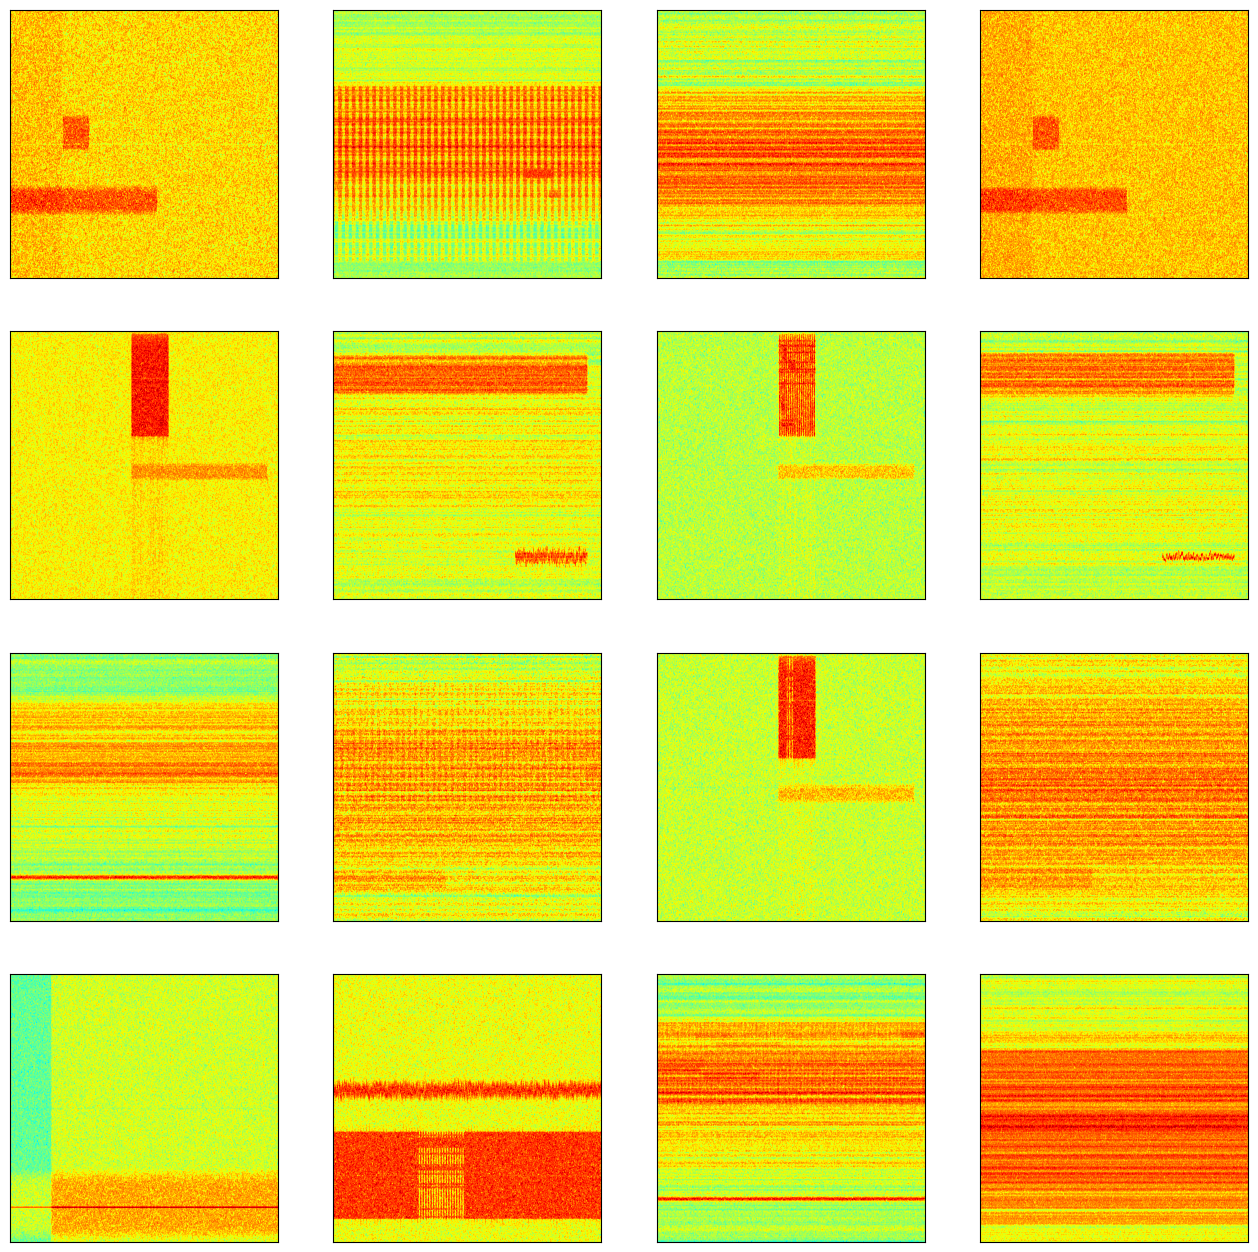

In [9]:
# Data Visualiser Function to see the bacth of spectrogram and investigate 

import numpy as np
import matplotlib.pyplot as plt

def visualize_data(data, visualize_transform=None):
    if visualize_transform:
        data = visualize_transform(data)

    batch_size = data.shape[0]
    figure = plt.figure(frameon=False)
    for sample_idx in range(batch_size):
        plt.subplot(
            int(np.ceil(np.sqrt(batch_size))),
            int(np.sqrt(batch_size)),
            sample_idx + 1,
        )
        extent = 0, data.shape[1], 0, data.shape[2]
        data_img = plt.imshow(
            data[sample_idx],
            vmin=np.min(data[sample_idx]),
            vmax=np.max(data[sample_idx]),
            cmap="jet",
            extent=extent,
        )
        plt.xticks([])
        plt.yticks([])

    return figure

data_loader = DataLoader(
    dataset=wideband_sig53_val,
    batch_size=16,
    shuffle=True,
)

for iq_data, _ in data_loader:
    figure = visualize_data(iq_data, visualize_transform=complex_spectrogram_to_magnitude)
    figure.set_size_inches(16, 16)
    plt.show()
    break


In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(data, visualize_transform=None, save_directory=None):
    if visualize_transform:
        data = visualize_transform(data)

    batch_size = data.shape[0]
    for sample_idx in range(batch_size):
        figure = plt.figure(frameon=False)
        ax = figure.add_subplot(111)

        extent = 0, data.shape[2], 0, data.shape[1]
        data_img = ax.imshow(
            data[sample_idx],
            vmin=np.min(data[sample_idx]),
            vmax=np.max(data[sample_idx]),
            cmap="jet",
            extent=extent,
        )
        ax.axis('off')

        if save_directory:
            save_path = os.path.join(save_directory, f"image_{sample_idx}.png")
            figure.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close(figure)
        else:
            plt.show()


# ...

save_directory = "test_image"
os.makedirs(save_directory, exist_ok=True)

data_loader = DataLoader(
    dataset=wideband_sig53_val,
    batch_size=20,
    shuffle=True,
)

for iq_data, _ in data_loader:
    visualize_data(iq_data, visualize_transform=complex_spectrogram_to_magnitude, save_directory=save_directory)
    break
